<a href="https://colab.research.google.com/github/harperd17/energy_volatility_prediction/blob/main/notebooks/EDA/vars_target_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is intended to show correlations between individual features and the target variable. They also show some interactions.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from google.colab import drive
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from pandas.api.types import is_numeric_dtype
import seaborn as sns

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!git clone https://github.com/harperd17/energy_volatility_prediction.git

Cloning into 'energy_volatility_prediction'...
remote: Enumerating objects: 547, done.
remote: Counting objects: 100% (547/547), done.
remote: Compressing objects: 100% (529/529), done.
remote: Total 547 (delta 330), reused 16 (delta 9), pack-reused 0
Receiving objects: 100% (547/547), 6.78 MiB | 8.71 MiB/s, done.
Resolving deltas: 100% (330/330), done.


In [ ]:
from energy_volatility_prediction.helpers.fengine import Fengine

In [ ]:
%cd /content/drive/Shareddrives/Data606_Energy/data

/content/drive/Shareddrives/Data606_Energy/data


In [ ]:
merged_data = pd.read_csv('./merge_ready/merged_data_2001-2020_new_data.csv')

In [ ]:
merged_data = merged_data[merged_data['target_COV']<0.15]

### Add some of the entity data and carbon policies in

In [ ]:
# variable to track whether states are part of a carbon pricing program - https://www.c2es.org/document/us-state-carbon-pricing-policies/
carbon_policy = ['WA','CA','ME','NH','VT','NY','MA','CT','RI','NJ','MD','DE','VA']
merged_data['Carbon Policy'] = merged_data['State'].isin(carbon_policy).astype(int)

# variable to show which region a state belongs to
# https://www.nerc.com/AboutNERC/keyplayers/Pages/default.aspx
WECC = ['WA','OR','CA','ID','NV','AZ','UT','MT','CO','WY','NM']
merged_data['WECC'] = merged_data['State'].isin(WECC).astype(int)
Texas_RE = ['TX']
merged_data['TX_RE'] = merged_data['State'].isin(Texas_RE).astype(int)
MRO = ['ND','SD','NE','KS','OK','MN','WI','IA']
merged_data['MRO'] = merged_data['State'].isin(MRO).astype(int)
RF = ['MI','IN','OH','WV','PA','NJ','DE','MD']
merged_data['RF'] = merged_data['State'].isin(RF).astype(int)
SERC = ['MO','AR','LA','IL','KY','TN','VA','NC','SC','GA','AL','MS','FL']
merged_data['SERC'] = merged_data['State'].isin(SERC).astype(int)
NPCC = ['NY','VT','NH','MA','CT','RI','ME']
merged_data['NPCC'] = merged_data['State'].isin(NPCC).astype(int)

## Look at Difference in target_COV between states with and without carbon policies

Text(0, 0.5, 'Target Coefficient of Variation')

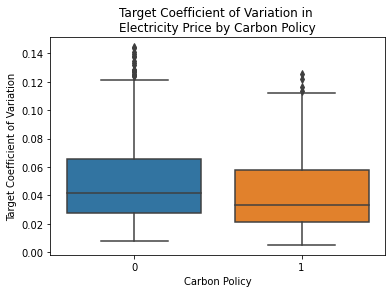

In [ ]:
sns.boxplot(x="Carbon Policy", y="target_COV", data=merged_data)
plt.title('Target Coefficient of Variation in \nElectricity Price by Carbon Policy')
plt.xlabel('Carbon Policy')
plt.ylabel('Target Coefficient of Variation')

In [ ]:
CA_CAP = ['CA','WA']
RGGI = ['ME','NH','VT','NY','MA','CT','RI','NJ','MD','DE','VA']
MA_CAP = ['MA']
#carbon_policy = ['WA','CA','ME','NH','VT','NY','MA','CT','RI','NJ','MD','DE','VA']
#df['Carbon Policy'] = df['State'].isin(carbon_policy).astype(int)
merged_data['CA Cap'] = merged_data['State'].isin(CA_CAP).astype(int)
merged_data['RGGI'] = merged_data['State'].isin(RGGI).astype(int)
merged_data['MA Cap'] = merged_data['State'].isin(MA_CAP).astype(int)

In [ ]:
merged_data['Policies'] = merged_data['CA Cap'] + merged_data['RGGI']*2 + merged_data['MA Cap']*3

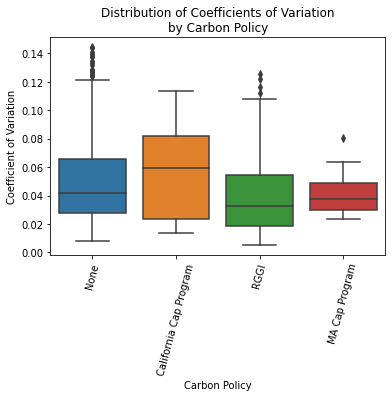

In [ ]:
sns.boxplot(x="Policies", y="target_COV", data=merged_data)
plt.title("Distribution of Coefficients of Variation\nby Carbon Policy")
plt.xlabel('Carbon Policy')
plt.ylabel('Coefficient of Variation')
plt.xticks(ticks=range(4),labels=['None','California Cap Program','RGGI','MA Cap Program','RGGI and MA Cap Program'],rotation=75);

## Look at Differences in target_COV between states within differen entities

In [ ]:
#merged_data['Combined'] = merged_data['WECC'] + merged_data['TX_RE']*2 + merged_data['MRO']*3 + merged_data['RF']*4 + merged_data['SERC']*5
merged_data['Combined'] = merged_data['NPCC'] + merged_data['RF']*2 + merged_data['TX_RE']*3 + merged_data['SERC']*4 + merged_data['WECC']*5 + merged_data['MRO']*6

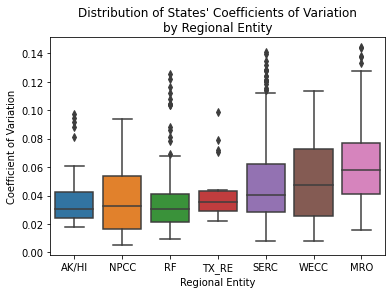

In [ ]:
sns.boxplot(x="Combined", y="target_COV", data=merged_data)
plt.xticks(ticks=range(7),labels=['AK/HI','NPCC','RF','TX_RE','SERC','WECC','MRO'])
plt.xlabel('Regional Entity')
plt.ylabel('Coefficient of Variation')
plt.title("Distribution of States' Coefficients of Variation\nby Regional Entity");

### Encode States

In [ ]:
def one_hot_encode(df,col,name=None):
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(np.array(df[col]).reshape(-1,1))
    encoded = encoder.transform(np.array(df[col]).reshape(-1,1))
    encoded_names = encoder.get_feature_names()
    new_names = []
    for name in encoded_names:
      if name[:3] == 'x0_':
        new_names.append(name[3:])
      else:
        new_names.append(col)
    df[new_names] = encoded
    #del df[col]
    return df

In [ ]:
merged_data = one_hot_encode(merged_data,'State')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
del merged_data['year.1']

## Look at which months temperature and drought data have the highest correlatin with the target_COV

In [ ]:
temp_cols = []
pdsi_cols = []
for col in merged_data.columns:
  if 'Temp' in col:
    temp_cols.append(col)
  elif 'PDSI' in  col or 'Drought' in col:
    pdsi_cols.append(col)
print(temp_cols)
print(pdsi_cols)

['Standardized Temp 1', 'Standardized Temp 2', 'Standardized Temp 3', 'Standardized Temp 4', 'Standardized Temp 5', 'Standardized Temp 6', 'Standardized Temp 7', 'Standardized Temp 8', 'Standardized Temp 9', 'Standardized Temp 10', 'Standardized Temp 11', 'Standardized Temp 12', 'Temp Averages 1', 'Temp Standard Deviations 1', 'Temp Averages 2', 'Temp Standard Deviations 2', 'Temp Averages 3', 'Temp Standard Deviations 3', 'Temp Averages 4', 'Temp Standard Deviations 4', 'Temp Averages 5', 'Temp Standard Deviations 5', 'Temp Averages 6', 'Temp Standard Deviations 6', 'Temp Averages 7', 'Temp Standard Deviations 7', 'Temp Averages 8', 'Temp Standard Deviations 8', 'Temp Averages 9', 'Temp Standard Deviations 9', 'Temp Averages 10', 'Temp Standard Deviations 10', 'Temp Averages 11', 'Temp Standard Deviations 11', 'Temp Averages 12', 'Temp Standard Deviations 12']
['Standardized Drought 1', 'Standardized Drought 2', 'Standardized Drought 3', 'Standardized Drought 4', 'Standardized Drought

In [ ]:
merged_data[temp_cols+['target_COV']].corr().abs()['target_COV'].sort_values(ascending=False)[:50]

target_COV                     1.000000
Temp Averages 7                0.317120
Temp Averages 8                0.303292
Temp Averages 6                0.283453
Temp Averages 9                0.243493
Temp Averages 5                0.233248
Temp Standard Deviations 4     0.208050
Temp Averages 4                0.202287
Temp Averages 10               0.196496
Temp Standard Deviations 8     0.189646
Temp Averages 3                0.181255
Temp Averages 2                0.148988
Temp Averages 11               0.126747
Temp Standard Deviations 10    0.124307
Standardized Temp 2            0.121506
Temp Averages 1                0.119955
Temp Standard Deviations 6     0.107560
Temp Averages 12               0.100532
Temp Standard Deviations 3     0.092306
Temp Standard Deviations 11    0.082714
Temp Standard Deviations 7     0.077624
Standardized Temp 11           0.070017
Standardized Temp 9            0.069667
Standardized Temp 12           0.065071
Temp Standard Deviations 9     0.060315


Temp Average 7 has the highest among temperature variables

In [ ]:
merged_data[pdsi_cols+['target_COV']].corr().abs()['target_COV'].sort_values(ascending=False)[:50]

target_COV                     1.000000
PDSI Averages 8                0.272580
PDSI Averages 12               0.267198
PDSI Averages 9                0.247177
PDSI Averages 7                0.245876
PDSI Averages 1                0.233026
PDSI Averages 2                0.229534
PDSI Averages 10               0.224747
PDSI Averages 5                0.221475
PDSI Averages 6                0.221428
PDSI Averages 3                0.211695
PDSI Standard Deviations 4     0.207362
PDSI Averages 11               0.204862
PDSI Averages 4                0.201526
PDSI Standard Deviations 2     0.174294
PDSI Standard Deviations 5     0.152234
PDSI Standard Deviations 3     0.142531
Standardized Drought 7         0.126198
Standardized Drought 6         0.125477
Standardized Drought 10        0.124692
Standardized Drought 9         0.122933
Standardized Drought 8         0.120262
Standardized Drought 12        0.116634
Standardized Drought 5         0.114771
PDSI Standard Deviations 9     0.114145


PDSI Averages 8 among the drought variables

In [ ]:
# remove the rest of the weather variables for the rest of this analysis
for col in merged_data.columns:
  if 'Temp Average' in col and '7' not in col:
    del merged_data[col]
  if 'PDSI Average' in col and '8' not in col:
    del merged_data[col]
  if 'Standardized Temp' in col or 'Standardized Drought' in col:
    del merged_data[col]
  if 'Standard Deviation' in col:
    del merged_data[col]

In [ ]:
to_del = []
for col in merged_data.columns:
  if col[:2] == 'R_':
    to_del.append(col)
merged_data = merged_data.drop(columns=to_del)

## Look at which of the remaining variables have the highest correlation with the target_COV

In [ ]:
merged_data.corr().abs()['target_COV'].sort_values(ascending=False)[:50]

target_COV                                                               1.000000
COV                                                                      0.779789
MO                                                                       0.399648
Temp Averages 7                                                          0.317120
Agg_R_Natural_Gas_count                                                  0.311283
Combined                                                                 0.290382
PDSI Averages 8                                                          0.272580
IA                                                                       0.262790
Agg_R_Geothermal_MWh                                                     0.233070
Agg_R_Hydroelectric_MWh                                                  0.232852
MRO                                                                      0.232664
Agg_R_Biomass_count                                                      0.229325
Agg_R_Hydroelect

## Now plot some of the top performing variables

In [ ]:
fig = px.scatter(merged_data, x='Temp Averages 7',y='target_COV',hover_data=['State','Year'])
fig.update_layout(
    title="Average July Temperature vs. Next Years Coefficient of Variation",
    xaxis_title="Average July Temperature",
    yaxis_title="Next Years Coefficient of Variation",
    )

In [ ]:
fig = px.scatter(merged_data, x='PDSI Averages 8',y='target_COV',hover_data=['State','Year'])
fig.update_layout(
    title="Average August PDSI vs. Next Years Coefficient of Variation",
    xaxis_title="Average August PDSI",
    yaxis_title="Next Years Coefficient of Variation",
    )

In [ ]:
fig = px.scatter(merged_data, x='Agg_R_Natural_Gas_count',y='target_COV',hover_data=['State','Year'])
fig.update_layout(
    title="Count of Natural Gas Plants vs. Next Years Coefficient of Variation",
    xaxis_title="Count of Natural Gas Plants",
    yaxis_title="Next Years Coefficient of Variation",
    )

In [ ]:
fig = px.scatter(merged_data, x='Agg_R_Geothermal_MWh',y='target_COV',hover_data=['State','Year'])
fig.update_layout(
    title="MWh of Geothermal Energy vs. Next Years Coefficient of Variation",
    xaxis_title="MWh of Geothermal Energy",
    yaxis_title="Next Years Coefficient of Variation",
    )

In [ ]:
fig = px.scatter(merged_data, x='Agg_R_Hydroelectric_MWh',y='target_COV',hover_data=['State','Year'])
fig.update_layout(
    title="MWh of Hydroelectric Energy vs. Next Years Coefficient of Variation",
    xaxis_title="MWh of Hydroelectric Energy",
    yaxis_title="Next Years Coefficient of Variation",
    )

In [ ]:
fig = px.scatter(merged_data, x='Agg_R_Biomass_count',y='target_COV',hover_data=['State','Year'])
fig.update_layout(
    title="Coefficient of Variation vs. Next Years Coefficient of Variation",
    xaxis_title="Coefficient of Variation",
    yaxis_title="Next Years Coefficient of Variation",
    )

In [ ]:
fig = px.scatter(merged_data, x='Mean Volume Weekly NG=F',y='target_COV',hover_data=['State','Year'])
fig.update_layout(
    title="Coefficient of Variation vs. Next Years Coefficient of Variation",
    xaxis_title="Coefficient of Variation",
    yaxis_title="Next Years Coefficient of Variation",
    )

In [ ]:
fig = px.scatter(merged_data, x='Mean Volume Weekly HO=F',y='target_COV',hover_data=['State','Year'])
fig.update_layout(
    title="Coefficient of Variation vs. Next Years Coefficient of Variation",
    xaxis_title="Coefficient of Variation",
    yaxis_title="Next Years Coefficient of Variation",
    )

In [ ]:
fig = px.scatter(merged_data, x='Mean Volume Weekly CL=F',y='target_COV',hover_data=['State','Year'])
fig.update_layout(
    title="Coefficient of Variation vs. Next Years Coefficient of Variation",
    xaxis_title="Coefficient of Variation",
    yaxis_title="Next Years Coefficient of Variation",
    )

# Now I want to look at whether there are significant interactions

In [ ]:
del merged_data['State']

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2,interaction_only=True)
polynomials = poly.fit_transform(merged_data)
polynomial_names = poly.get_feature_names(merged_data.columns)
poly_x = pd.DataFrame(polynomials,columns=polynomial_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
all_corrs = []
cols = []
for col in list(poly_x.columns)[1:]:
  if not 'target_COV' in col:
    cols.append(col)
    all_corrs.append(np.array(poly_x[[col,'target_COV']].corr())[0][1])
#poly_x.corr().abs()['target_COV'].sort_values(ascending=False)[:50]

In [ ]:
corrs_df = pd.Series(all_corrs, index=cols)

In [ ]:
# remove anything interacting with target_COV or COV
non_cov_cols = []
for col in cols:
  if not 'COV' in col and not 'MO' in col:
    non_cov_cols.append(col)

In [ ]:
corrs_df[non_cov_cols].abs().sort_values(ascending=False)[:50]

Agg_R_Natural_Gas_count Combined                                  0.396458
Agg_R_Coal_MWh PDSI Averages 8                                    0.358039
Agg_R_Natural_Gas_count x                                         0.347311
Agg_R_Oil_Gas_count Combined                                      0.345119
Agg_R_Oil_Gas_count PDSI Averages 8                               0.333558
Agg_R_Natural_Gas_count PDSI Averages 8                           0.322694
Temp Averages 7                                                   0.317120
Agg_R_Natural_Gas_count y                                         0.314494
Agg_R_Natural_Gas_count Temp Averages 7                           0.313040
COM_percapita_mean_kWh_statepop Agg_R_Natural_Gas_count           0.311693
Agg_R_Natural_Gas_count Agg_R_Oil_Gas_count                       0.311456
Agg_R_Natural_Gas_count                                           0.311283
Agg_R_Natural_Gas_count Months Above Average Price Volume CL=F    0.310216
Year Agg_R_Natural_Gas_co

## Plot the interactions with the 15 highest correlations

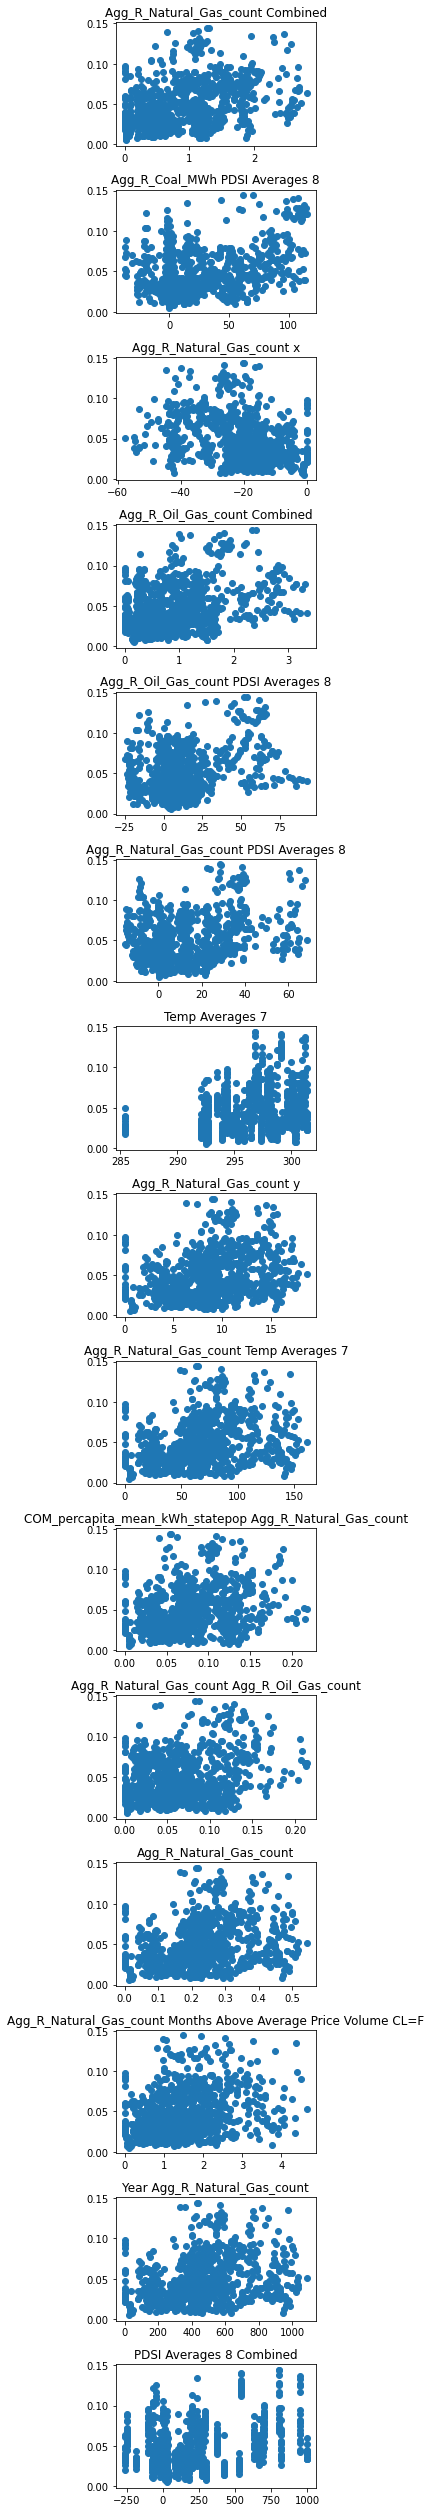

In [ ]:
fig, ax = plt.subplots((15))
fig.set_size_inches(5,35)
for i in range(15):
  ax[i].scatter(poly_x[corrs_df[non_cov_cols].abs().sort_values(ascending=False).index[i]],poly_x['target_COV'])
  ax[i].set_title(corrs_df[non_cov_cols].abs().sort_values(ascending=False).index[i])
fig.tight_layout()

Overall, these interaction look nice and useful. However, they will only be useful in a non-tree based model since tree based models already take into account interactions in a way. Currently, our best models by far are tree based models, so these interactions may not get used.